# From Training to Deployment with TensorFlow and OpenVINO™ 



#### Table of contents:

- [TensorFlow Image Classification Training](#TensorFlow-Image-Classification-Training)
- [Import TensorFlow and Other Libraries](#Import-TensorFlow-and-Other-Libraries)
- [Download and Explore the Dataset](#Download-and-Explore-the-Dataset)
- [Load Using keras.preprocessing](#Load-Using-keras.preprocessing)
- [Create a Dataset](#Create-a-Dataset)
- [Visualize the Data](#Visualize-the-Data)
- [Configure the Dataset for Performance](#Configure-the-Dataset-for-Performance)
- [Standardize the Data](#Standardize-the-Data)
- [Create the Model](#Create-the-Model)
- [Compile the Model](#Compile-the-Model)
- [Model Summary](#Model-Summary)
- [Train the Model](#Train-the-Model)
- [Visualize Training Results](#Visualize-Training-Results)
- [Overfitting](#Overfitting)
- [Data Augmentation](#Data-Augmentation)
- [Dropout](#Dropout)
- [Compile and Train the Model](#Compile-and-Train-the-Model)
- [Visualize Training Results](#Visualize-Training-Results)
- [Predict on New Data](#Predict-on-New-Data)
- [Save the TensorFlow Model](#Save-the-TensorFlow-Model)
- [Convert the TensorFlow model with OpenVINO Model Conversion API](#Convert-the-TensorFlow-model-with-OpenVINO-Model-Conversion-API)
- [Preprocessing Image Function](#Preprocessing-Image-Function)
- [OpenVINO Runtime Setup](#OpenVINO-Runtime-Setup)
    - [Select inference device](#Select-inference-device)
- [Run the Inference Step](#Run-the-Inference-Step)
- [The Next Steps](#The-Next-Steps)



In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copyright 2018 The TensorFlow Authors
#
# Modified for OpenVINO Notebooks

This tutorial demonstrates how to train, convert, and deploy an image classification model with TensorFlow and OpenVINO. This particular notebook shows the process where we perform the inference step on the freshly trained model that is converted to OpenVINO IR with model conversion API. For faster inference speed on the model created in this notebook, check out the [Post-Training Quantization with TensorFlow Classification Model](./301-tensorflow-training-openvino-nncf.ipynb) notebook.


This training code comprises the official [TensorFlow Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification) in its entirety.

The `flower_ir.bin` and `flower_ir.xml` (pre-trained models) can be obtained by executing the code with 'Runtime->Run All' or the `Ctrl+F9` command.

In [2]:
import platform

%pip install -q "openvino>=2023.1.0" "pillow"
if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"
%pip install -q "tensorflow-macos>=2.5; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow-macos>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version <= '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version <= '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q "tensorflow>=2.5,<=2.12.0; sys_platform != 'darwin' and python_version <= '3.8'"
%pip install -q tf_keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## TensorFlow Image Classification Training
[back to top ⬆️](#Table-of-contents:)


The first part of the tutorial shows how to classify images of flowers (based on the TensorFlow's official tutorial). It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model

## Import TensorFlow and Other Libraries
[back to top ⬆️](#Table-of-contents:)


In [3]:
import os
import sys
from pathlib import Path

os.environ["TF_USE_LEGACY_KERAS"] = "1"

import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import openvino as ov

sys.path.append("../utils")
from notebook_utils import download_file

2024-03-24 19:33:33.885606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 19:33:33.929925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 19:33:34.624331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download and Explore the Dataset
[back to top ⬆️](#Table-of-contents:)


This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

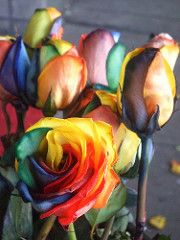

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

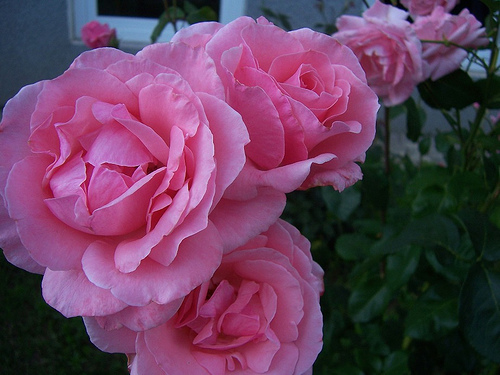

In [7]:
PIL.Image.open(str(roses[1]))

And some tulips:

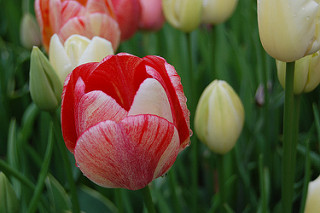

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

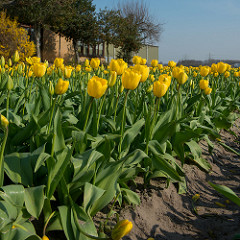

In [9]:
PIL.Image.open(str(tulips[1]))

## Load Using keras.preprocessing
[back to top ⬆️](#Table-of-contents:)

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a Dataset
[back to top ⬆️](#Table-of-contents:)


Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-03-24 19:33:35.879331: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the Data
[back to top ⬆️](#Table-of-contents:)

Here are the first 9 images from the training dataset.

2024-03-24 19:33:36.309931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


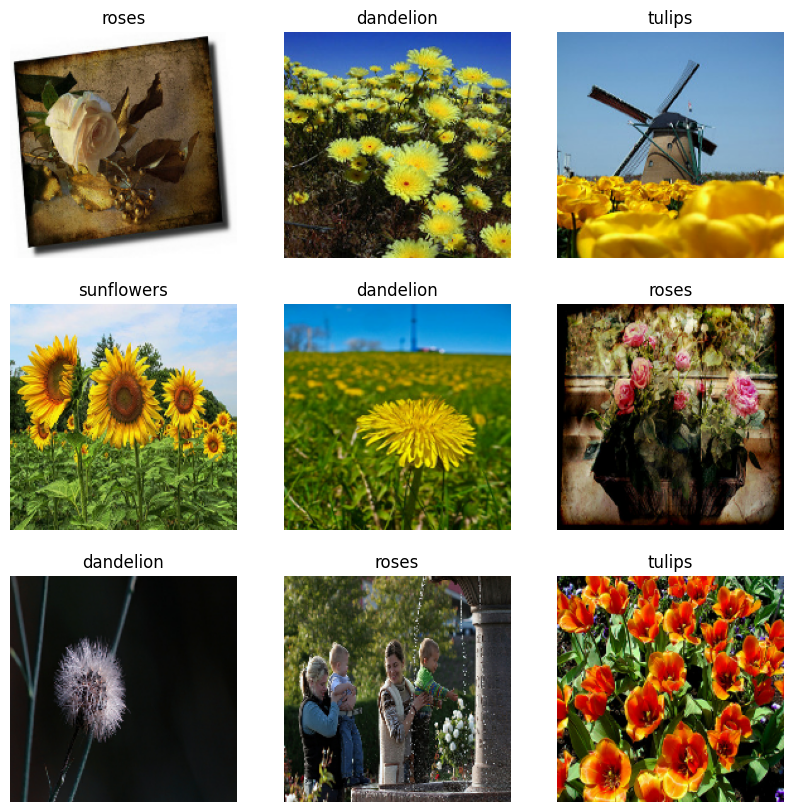

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the Dataset for Performance
[back to top ⬆️](#Table-of-contents:)

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data
[back to top ⬆️](#Table-of-contents:)


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Create the Model
[back to top ⬆️](#Table-of-contents:)

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [19]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

## Compile the Model
[back to top ⬆️](#Table-of-contents:)

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary
[back to top ⬆️](#Table-of-contents:)

View all the layers of the network using the model's `summary` method.

> **NOTE:** This section is commented out for performance reasons. Please feel free to uncomment these to compare the results.

In [21]:
# model.summary()

## Train the Model
[back to top ⬆️](#Table-of-contents:)


In [22]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

## Visualize Training Results
[back to top ⬆️](#Table-of-contents:)

Create plots of loss and accuracy on the training and validation sets.

In [23]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting
[back to top ⬆️](#Table-of-contents:)

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data Augmentation
[back to top ⬆️](#Table-of-contents:)

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [24]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                   img_width,
                                   3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

2024-03-24 19:33:39.951285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


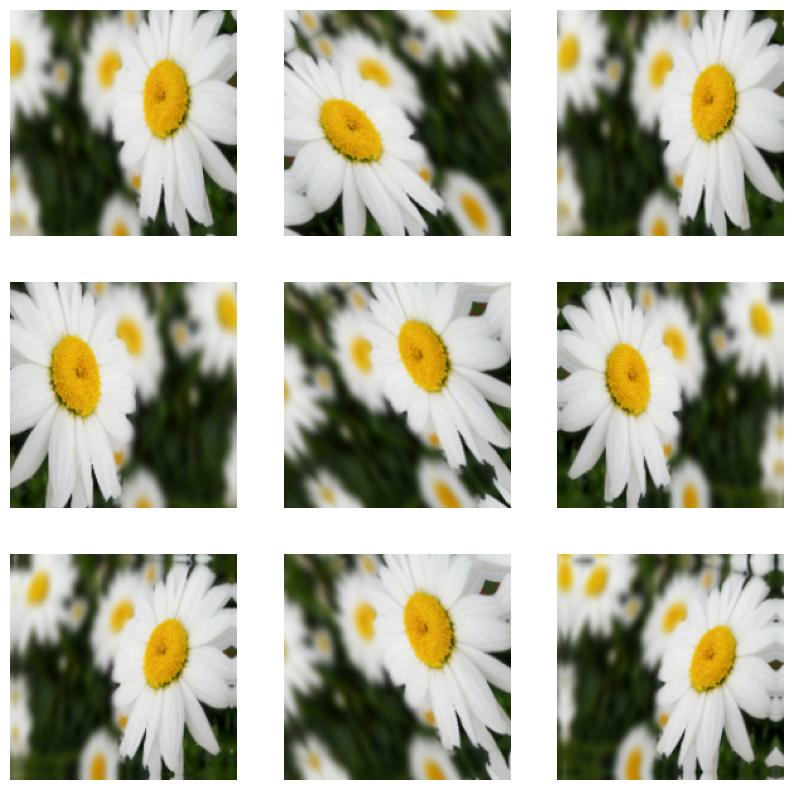

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout
[back to top ⬆️](#Table-of-contents:)

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [26]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, name="outputs")
])

## Compile and Train the Model
[back to top ⬆️](#Table-of-contents:)


In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [29]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 15s 61ms/step - loss: 1.2556 - accuracy: 0.4646 - val_loss: 1.0774 - val_accuracy: 0.5559
Epoch 2/15
92/92 [==============================] - 5s 55ms/step - loss: 1.0002 - accuracy: 0.6069 - val_loss: 0.9504 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 5s 54ms/step - loss: 0.9065 - accuracy: 0.6468 - val_loss: 0.9434 - val_accuracy: 0.6335
Epoch 4/15
92/92 [==============================] - 5s 55ms/step - loss: 0.8338 - accuracy: 0.6781 - val_loss: 0.8590 - val_accuracy: 0.6594
Epoch 5/15
92/92 [==============================] - 5s 54ms/step - loss: 0.7951 - accuracy: 0.6904 - val_loss: 0.8011 - val_accuracy: 0.6880
Epoch 6/15
92/92 [==============================] - 5s 54ms/step - loss: 0.7310 - accuracy: 0.7224 - val_loss: 0.7539 - val_accuracy: 0.6948
Epoch 7/15
92/92 [==============================] - 5s 55ms/step - loss: 0.6877 - accuracy: 0.7343 - val_loss: 0.8335 - val_accuracy: 0.6744
Epoch 8/15
9

## Visualize Training Results
[back to top ⬆️](#Table-of-contents:)

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

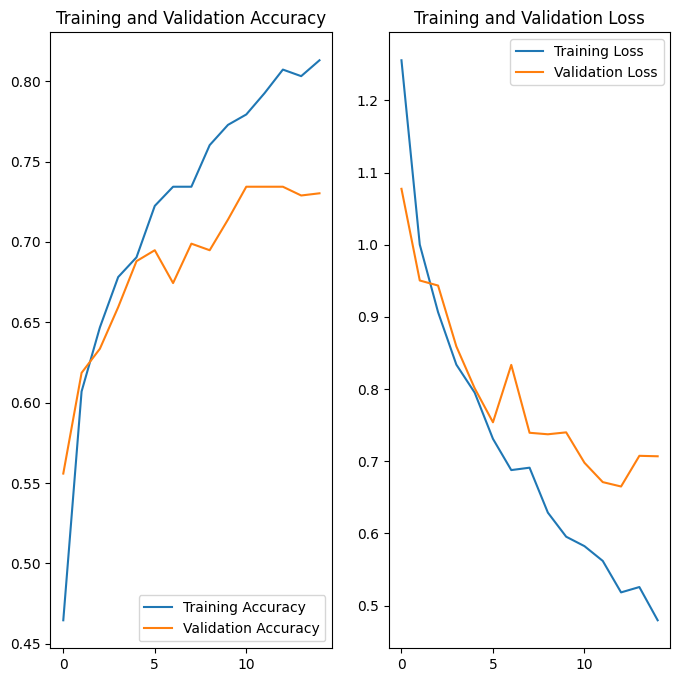

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on New Data
[back to top ⬆️](#Table-of-contents:)

Finally, let us use the model to classify an image that was not included in the training or validation sets.

> **Note**: Data augmentation and Dropout layers are inactive at inference time.

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 372ms/step
This image most likely belongs to sunflowers with a 99.99 percent confidence.


## Save the TensorFlow Model
[back to top ⬆️](#Table-of-contents:)


In [32]:
#save the trained model - a new folder flower will be created
#and the file "saved_model.h5" is the pre-trained model
model_dir = "model"
saved_model_path = f"{model_dir}/flower/saved_model"
model.save(saved_model_path)

INFO:tensorflow:Assets written to: model/flower/saved_model/assets


INFO:tensorflow:Assets written to: model/flower/saved_model/assets


## Convert the TensorFlow model with OpenVINO Model Conversion API
[back to top ⬆️](#Table-of-contents:)
To convert the model to OpenVINO IR with `FP16` precision, use model conversion Python API.

In [33]:
# Convert the model to ir model format and save it.
ir_model_path = Path("model/flower")
ir_model_path.mkdir(parents=True, exist_ok=True)
ir_model = ov.convert_model(saved_model_path, input=[1,180,180,3])
ov.save_model(ir_model, ir_model_path / "flower_ir.xml")

## Preprocessing Image Function
[back to top ⬆️](#Table-of-contents:)


In [34]:
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

## OpenVINO Runtime Setup
[back to top ⬆️](#Table-of-contents:)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [35]:
import ipywidgets as widgets

# Initialize OpenVINO runtime
core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [36]:
class_names=["daisy", "dandelion", "roses", "sunflowers", "tulips"]

compiled_model = core.compile_model(model=ir_model, device_name=device.value)

del ir_model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

## Run the Inference Step
[back to top ⬆️](#Table-of-contents:)


'output/A_Close_Up_Photo_of_a_Dandelion.jpg' already exists.
(1, 180, 180, 3)
[1,180,180,3]
This image most likely belongs to dandelion with a 99.79 percent confidence.


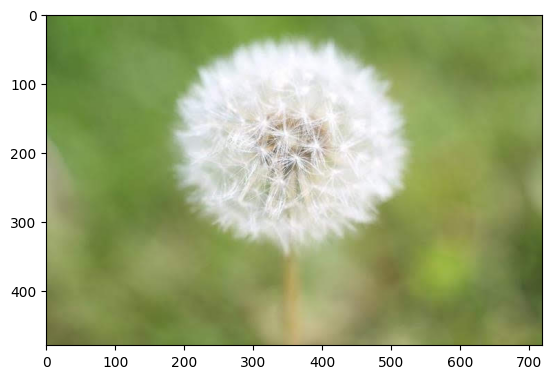

In [37]:
# Run inference on the input image...
inp_img_url = "https://upload.wikimedia.org/wikipedia/commons/4/48/A_Close_Up_Photo_of_a_Dandelion.jpg"
OUTPUT_DIR = "output"
inp_file_name = f"A_Close_Up_Photo_of_a_Dandelion.jpg"
file_path = Path(OUTPUT_DIR)/Path(inp_file_name)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the image
download_file(inp_img_url, inp_file_name, directory=OUTPUT_DIR)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(file_path)

print(input_image.shape)
print(input_layer.shape)
res = compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## The Next Steps
[back to top ⬆️](#Table-of-contents:)

This tutorial showed how to train a TensorFlow model, how to convert that model to OpenVINO's IR format, and how to do inference on the converted model. For faster inference speed, you can quantize the IR model. To see how to quantize this model with OpenVINO's [Post-training Quantization with NNCF Tool](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/quantizing-models-post-training/basic-quantization-flow.html), check out the [Post-Training Quantization with TensorFlow Classification Model](./301-tensorflow-training-openvino-nncf.ipynb) notebook.